## Smart water flooding analytical solution
This document is mostly based on the SPE-7660 paper by Gary Pope. I first implement the simple water flooding analytical solution and then expand it to low salinity water flooding with and without ionic adsorption.

## Mathematical model
The two phase flow equation in a 1D porous medium reads
$$\frac{\partial S_w}{\partial t}+\frac{u}{\varphi}\frac{df_w}{dS_w}\frac{\partial S_w}{\partial x} = 0 $$
The dimensionless time and space are defined as
$$t_D = \frac{ut}{\varphi L}$$ and
$$x_D = \frac{x}{L}$$
The velocity of a constant saturation front is calculated by
$$V_{S_w} = (\frac{dx}{dt})_{S_w}=\frac{u}{\varphi}\frac{df_w}{dS_w}$$
The shock front is specified by
$$\frac{f_w(S_{w,shock})-f_w(S_{w,init})}{S_{w,shock}-S_{w,init}}=\left(\frac{df_w}{dS_w}\right)_{S_{w,shock}}$$
The injected water front velocity (i.e., a tracer in the injected water, or the low salinity of the injected brine) is calculated by
$$V_{c} = (\frac{dx}{dt})_{c}=\frac{u}{\varphi}\frac{f_w}{S_w}$$
an the water saturation that corresponds to the position of the salinity front is given by
$$\frac{f_w(S_{w,s})-f_w(0)}{S_{w}-0.0}=\left(\frac{df_w}{dS_w}\right)_{S_{w,shock}}$$
which is the tangent line fron the point (0,0) to the $f_w-S_w$ (fractional flow) curve.
The breakthrough time (in number of pore volume) is calculated by
$$t_{D, bt} = \left(\frac{df_w}{dS_w}\right)^{-1}_{S_{w,shock}}$$
The other useful relation is the average saturation after breakthrough, which reads
$$S_{w,av} = S_{or}+\left[(1-f_w)\left(\frac{df_w}{dS_w}\right)\right]_{x=L}, \;t_D>t_{D,bt}$$ 
The recovery factor then can be calculated based on the fact that the recovery curve is linear until the breakthrough, and after breakthrough it gradually reaches a plateau. The oil recovery factor before the breakthrough is calculated by
$$R = \frac{(1-f_w(S_{w,init}))t_D}{1-S_{w,init}}, \;t_D<t_{D,bt}$$ and after breakthrough by
$$R = \frac{S_{w,init}-S_{w,av}}{1-S_{w,init}}, \; t_D>t_{D,bt}$$
Let's try the above formulation in Julia.

## Testing the codes
The `FractionalFlow.jl` package is built to solve and visualize the analytical solutions to several injection problem in the petroleum engineering, including water flooding, low salinity water flooding with and without ionic adsorption, and solvent flooding (carbonated water, DME, etc). There are several functions that are documented in the code. Here, I show by example how to define a problem, solve it, and visualize the results.

In [134]:
include("FractionalFlow.jl")
using PyPlot
FF = FractionalFlow

FractionalFlow

## Water flooding

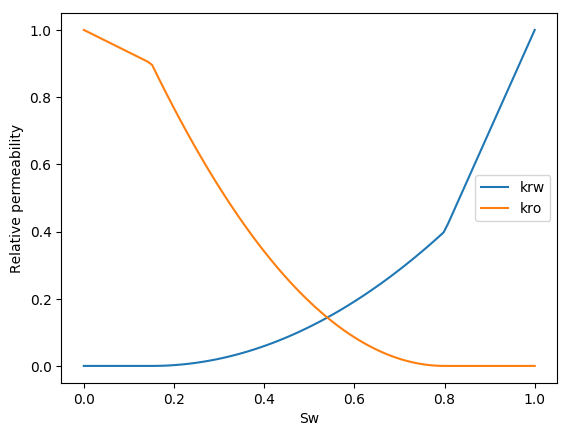

PyObject <matplotlib.legend.Legend object at 0x7fea2cccbd50>

In [135]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
FF.visualize(rel_perms)

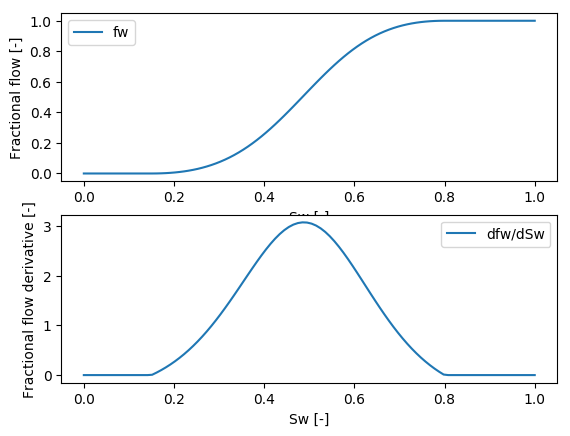

PyObject <matplotlib.legend.Legend object at 0x7fea2cedeed0>

In [136]:
# define the fluids
fluids = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
FF.visualize(rel_perms, fluids)

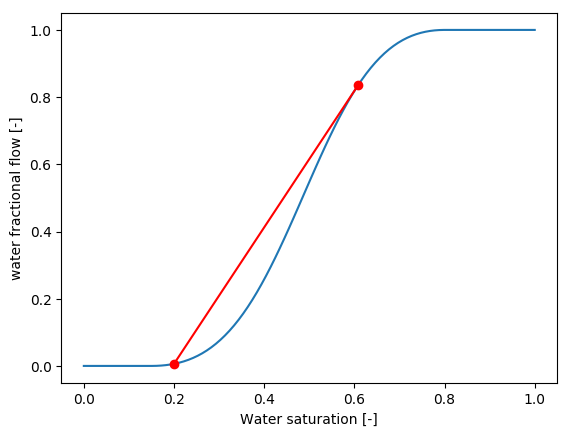

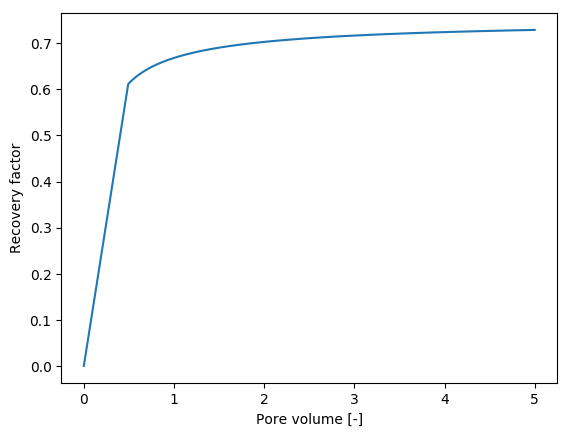

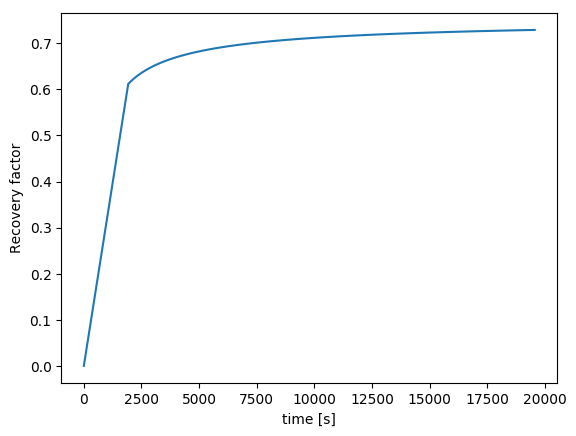

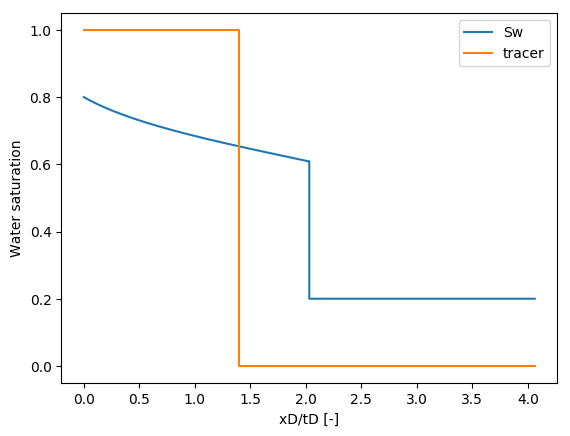

sw_shock = 0.608438467199255
breakthrough time = 0.4922812627958595


PyObject <matplotlib.legend.Legend object at 0x7fea3808af10>

In [137]:
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5.0, 
    p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties()
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = linspace(0,1,100)
# plot(sw_tmp, fw.(sw_tmp), xlabel = "Sw", ylabel="fw", label="")
# plot!(sw_tmp, dfw.(sw_tmp))
# figure(1)
# plot(pv, R) 
# xlabel("PV injected")
# ylabel("Recovery factor") 
# title("Water flooding")
# figure(2)
# plot(xt, sw)
# xlabel("x/t [-]")
# ylabel("Water saturation [-]")
FF.visualize(wf_res)

## Low salinity water flooding - with/without adsorption

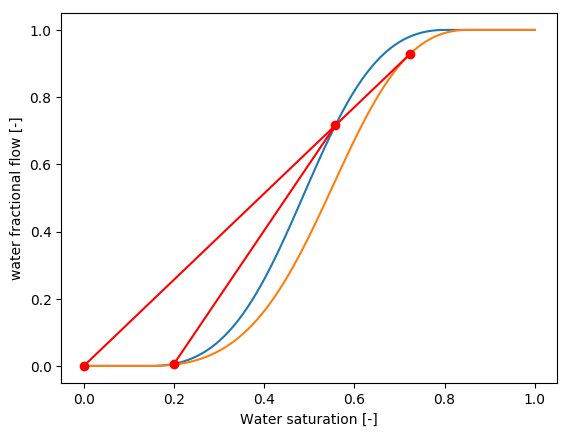

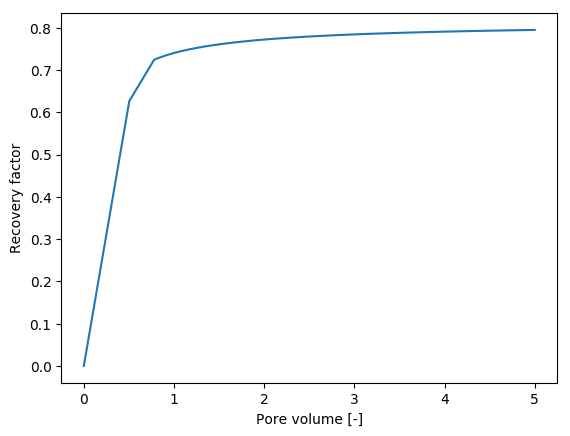

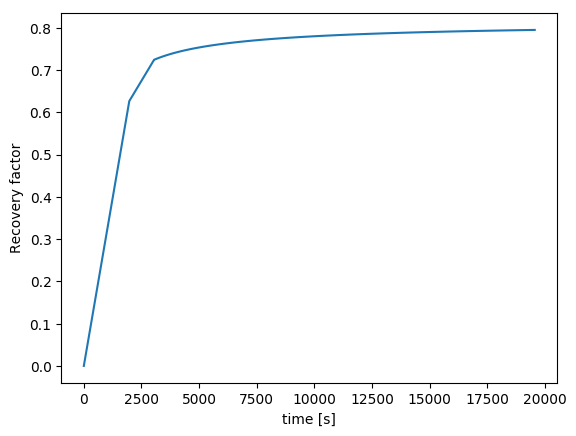

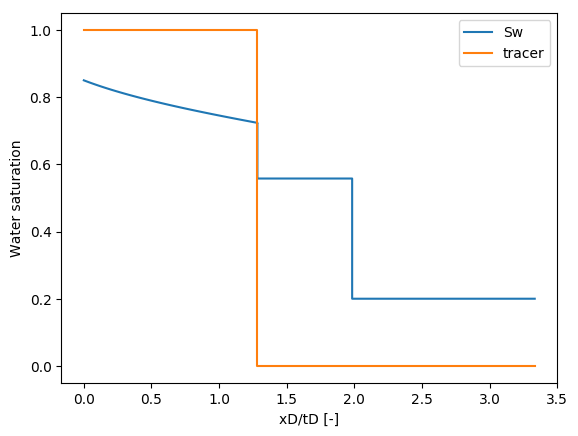

low sal sw_shock = 0.7233666450788676
low sal breakthrough time = 0.7792345274868723
high sal sw_shock = 0.5577460825529506
high sal breakthrough time = 0.5041328948599879


PyObject <matplotlib.legend.Legend object at 0x7fea2d4a7890>

In [138]:
fluids_hs = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=0.2, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5.0, p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
ls_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
FF.visualize(ls_res)

## compare with numeric

In [139]:
# t_sec, pv_num, rec_fact, xt_num, sw_num, c_old, c_out_sal = 
#     FF.forced_imb_implicit_upwind(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
#         rel_perms_ls, core_flood)
# plot(ls_res)

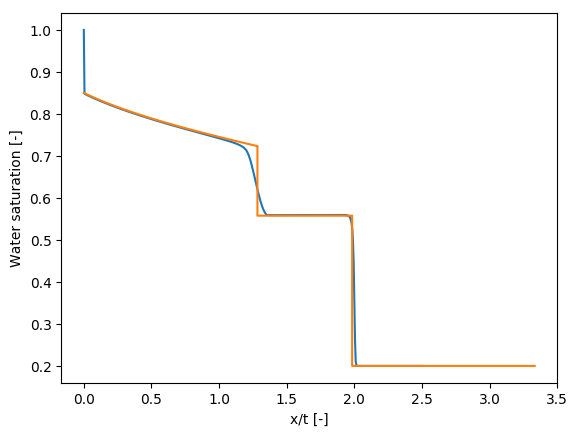

PyObject Text(24,0.5,'Water saturation [-]')

In [140]:
figure(2)
plot(xt_num/(core_props.length)/0.4, sw_num)
plot(ls_res.saturation_profile_xt[:,1], ls_res.saturation_profile_xt[:,2])
xlabel("x/t [-]")
ylabel("Water saturation [-]")

## Low salinity flooding, an exceptional case

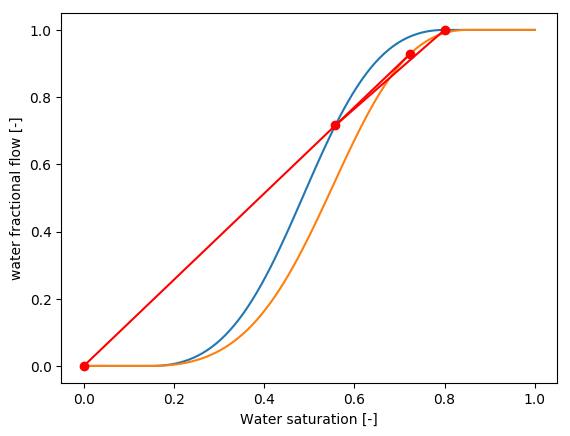

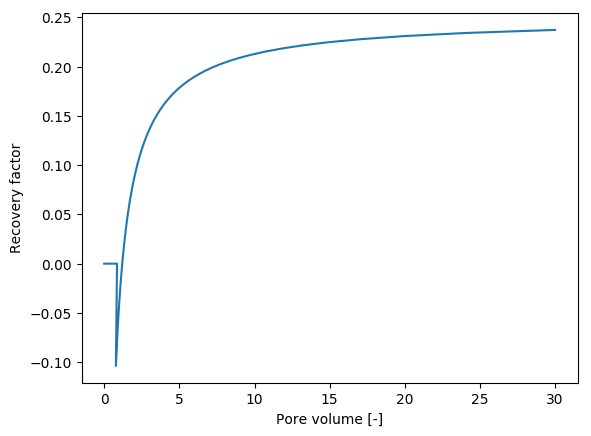

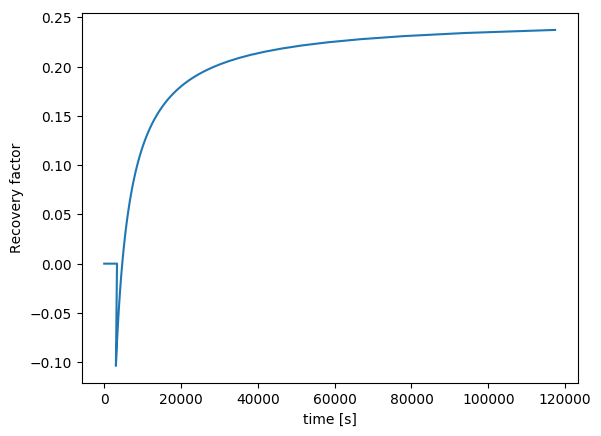

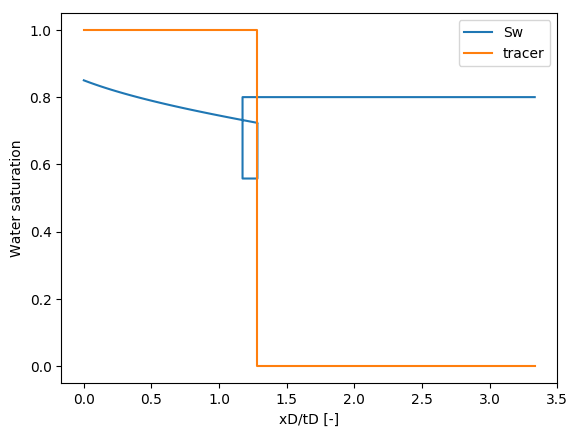

low sal sw_shock = 0.7233666450788676
low sal breakthrough time = 0.7792345274868723
high sal sw_shock = 0.5577460825529506
high sal breakthrough time = 0.8522910391556234


INFO: This function does not work on this problem. Consider calling the single_ion_adsorption_water_flood_single_shock function.


PyObject <matplotlib.legend.Legend object at 0x7fea2cf9bbd0>

In [141]:
sor_hs = 0.20
sw_init = 1-sor_hs
fluids_hs = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=sor_hs, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=30.0, p_back=1e5, sw_init=sw_init, 
    sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
ls_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
FF.visualize(ls_res)

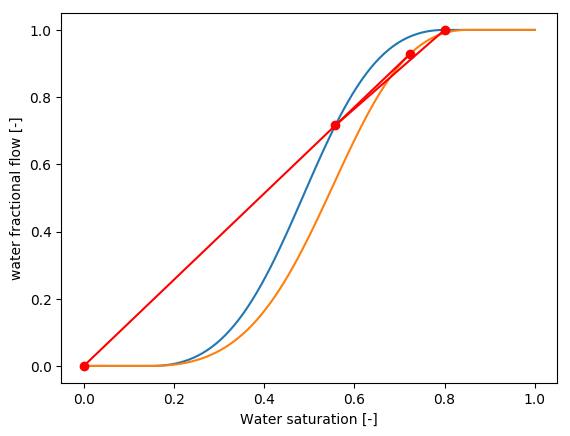

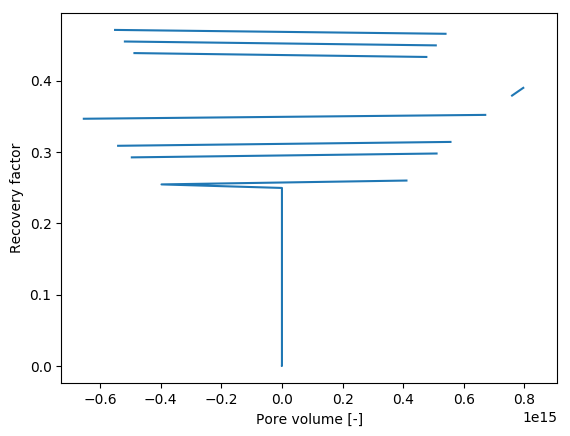

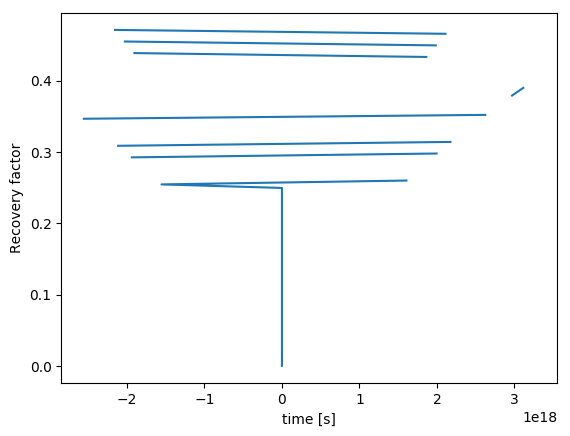

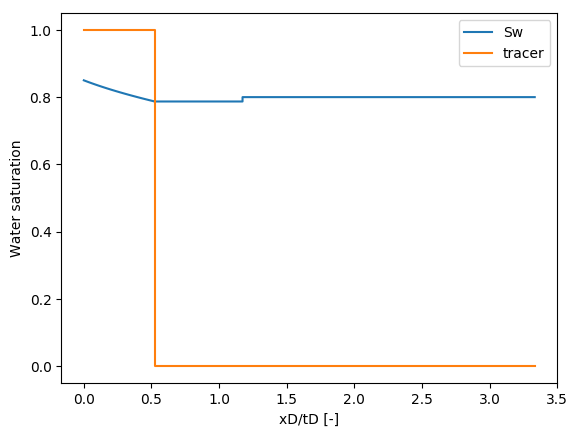

low sal sw_shock = 0.7233666450788676
low sal breakthrough time = 0.7792345274868723
high sal sw_shock = 0.5577460825529506
high sal breakthrough time = 0.8522910391556234
sw_shock = 0.7870029917024813
high sal breakthrough time = 0.8522910391556275
low sal breakthrough time = 1.9087615410426133
swmax 0.8942149449211839


PyObject <matplotlib.legend.Legend object at 0x7fea2c896e90>

In [142]:
sor_hs = 0.20
sw_init = 1-sor_hs
fluids_hs = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=sor_hs, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=30.0, p_back=1e5, sw_init=sw_init, 
    sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
ls_res = FF.single_ion_adsorption_water_flood_single_shock(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood, 0.0)
FF.visualize(ls_res)

## Solvent injection: DME example

In [143]:
ls_res.recovery_pv

103×2 Array{Real,2}:
   0.0           0.0       
   1.90876       0.0       
   1.90876       0.00247275
   1.90876       0.0805532 
   1.94985       0.0836276 
   1.99246       0.0866979 
   2.03668       0.089764  
   2.0826        0.0928257 
   2.13031       0.0958831 
   2.17992       0.098936  
   2.23154       0.101984  
   2.28529       0.105028  
   2.34131       0.108067  
   ⋮                       
 Inf           NaN         
   4.46145e14    0.416927  
 Inf           NaN         
 Inf           NaN         
   4.76319e14    0.433172  
  -4.86597e14    0.438586  
 Inf           NaN         
   5.0748e14     0.449416  
  -5.18087e14    0.45483   
 Inf           NaN         
   5.39629e14    0.46566   
  -5.50564e14    0.471075  

In [144]:
# Pkg.add("ProgressMeter")